# IHLT Project


In [24]:
import pandas as pd
import csv

## Load data

In [25]:
TRAIN_PATH = '../data/train/'
TEST_PATH = '../data/test/'

def load_data(path, files):
    # Read first file
    dt = pd.read_csv(path + 'STS.input.' + files[0] + '.txt', sep='\t', quoting=csv.QUOTE_NONE, header=None, names=['s1', 's2'])
    dt['gs'] = pd.read_csv(path + 'STS.gs.' + files[0] + '.txt', sep='\t', header=None, names=['gs'])
    # Concatenate the rest of files
    for f in files[1:]:
        dt2 = pd.read_csv(path + 'STS.input.' + f + '.txt', sep='\t', quoting=csv.QUOTE_NONE, header=None, names=['s1', 's2'])
        dt2['gs'] = pd.read_csv(path + 'STS.gs.' + f + '.txt', sep='\t', header=None, names=['gs'])
        dt = pd.concat([dt, dt2], ignore_index=True)
    return dt

## Compute Features

In [26]:
def add_dummy_features(df):
    df['s1_len'] = df['s1'].apply(len)
    df['s2_len'] = df['s2'].apply(len)
    df['s1_words'] = df['s1'].apply(lambda x: len(x.split()))
    df['s2_words'] = df['s2'].apply(lambda x: len(x.split()))
    df['dif_len'] = df.apply(lambda row: abs(row['s1_len'] - row['s2_len']), axis=1)
    df['dif_words'] = df.apply(lambda row: abs(row['s1_words'] - row['s2_words']), axis=1)
    return df

## Create models

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def train_NN(df, input, output):
    X = df[input]
    y = df[output]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu'))
    model.add(Dense(5, activation='relu'))               
    model.add(Dense(1))                                   
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
    return history, model


In [28]:
import matplotlib.pyplot as plt

def plot_history(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Basic pipeline

### Train a model

(2234, 3)
Epoch 1/50


d:\projects\MAI\IHLT\Intro-to-IHLT-Labs\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8735 - mae: 2.4942 - val_loss: 7.1776 - val_mae: 2.2999
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1736 - mae: 2.2474 - val_loss: 6.4733 - val_mae: 2.1555
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6312 - mae: 2.1381 - val_loss: 6.1368 - val_mae: 2.1076
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5121 - mae: 2.0062 - val_loss: 5.6460 - val_mae: 2.0533
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0426 - mae: 1.9048 - val_loss: 3.8924 - val_mae: 1.6735
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5139 - mae: 1.5792 - val_loss: 3.6405 - val_mae: 1.6267
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5498 - mae: 1.5179 - val_loss: 3.2234 - val_mae: 1.5052
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0741 - mae: 1.4305 - val_loss: 3.0345 - val_mae: 1.4801
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6531 - mae: 1.3352 - va

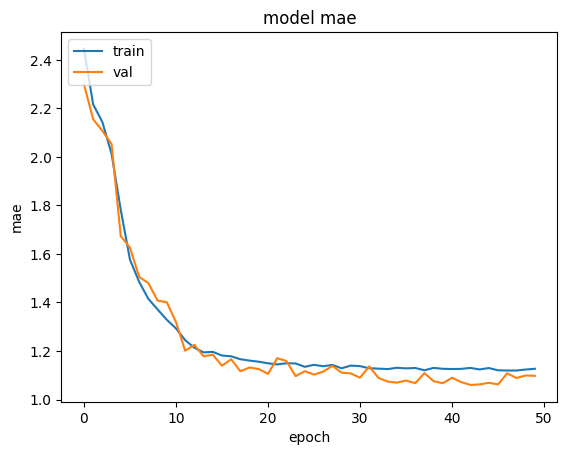

In [29]:
# Create the desired features
def add_features(dt):
    add_dummy_features(dt)

# Load train data
all_train_files = ['SMTeuroparl', 'MSRvid', 'MSRpar']
df = load_data(TRAIN_PATH, all_train_files)
print(df.shape)
df.tail(5)

# Add features to the train data
add_features(df)

# Features to use in the model
features = ['dif_len', 'dif_words']
# Train the model
hist, model = train_NN(df, features, 'gs')
plot_history(hist)


## Compute correlation of the model

In [30]:
from scipy.stats import pearsonr

# Load test data
# Doubt: The files with the same name are the same files as in the training set? If so, we have to use them also for testing?
all_test_files = ['SMTeuroparl', 'MSRvid', 'MSRpar', 'surprise.OnWN', 'surprise.SMTnews']
df_test = load_data(TEST_PATH, all_test_files)

# Add the features to the test data
add_features(df_test)
# Fill column of the dataset with the predictions of the model
df_test['predicted'] = model.predict(df_test[features])

# Compute the Pearson correlation between the predictions and the gold standard
corr = pearsonr(df_test['gs'], df_test['predicted'])[0]
print('Pearson correlation:', corr)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
Pearson correlation: 0.005225526669752012
